### Функции для преобразования таблиц

In [1]:
import numpy as np
import pandas as pd
from pylab import *
from scipy import stats
from pandas import plotting

Polynomial = np.polynomial.Polynomial

table_name = "Data.xlsx"
Observations = []

header_names = [
    'Station',
    'Horizon',
    'pH',
    'Temp',
    'Oxygen',
    'BOD5',
    'PO',
    'Chlorides',
    'Alkalinity',
    'Ca',
    'Mg',
    'HardnessOfWater',
    'Fe',
    'Nitrites',
    'Phosphates']

def TransformTable(df):
    #Filling empty rows
    df.Station = pd.Series(df.Station).fillna(method='ffill')

    #Set dtype to columns
    df.Station = df.Station.replace(r"Ок 1", "15")
    df.Station = pd.to_numeric(df.Station, downcast='integer')

    df.pH = pd.to_numeric(df.pH)
    df.Temp = pd.to_numeric(df.Temp)
    df.Oxygen = pd.to_numeric(df.Oxygen)
    df.PO = pd.to_numeric(df.PO)
    df.Chlorides = pd.to_numeric(df.Chlorides)
    df.Alkalinity = pd.to_numeric(df.Alkalinity)
    df.Ca = pd.to_numeric(df.Ca)
    df.Mg = pd.to_numeric(df.Mg)
    df.HardnessOfWater = pd.to_numeric(df.HardnessOfWater)
    df.Fe = pd.to_numeric(df.Fe)
    df.Nitrites = pd.to_numeric(df.Nitrites)
    df.Phosphates = pd.to_numeric(df.Phosphates)

    df.BOD5 = pd.to_numeric(df.BOD5)

    df.Horizon = df.Horizon.replace({r"\Aд\D\D": "bottom", "пов.": "surface"}, regex=True)

    return df

def ConvertToDFArr(ExcelFileName: str) -> list:
    Init_table = pd.ExcelFile(ExcelFileName)
    for i in Init_table.sheet_names:
        Year = pd.read_excel(Init_table, sheet_name=i, header=0, names = header_names)
        Year = Year.drop(0, 0)
        Year = TransformTable(Year)
        Observations.append(Year)
    return Observations

def GetTimelineTable(list_of_frames, column, value, horizon='bottom'):
    result = pd.DataFrame(columns = header_names)
    for i in list_of_frames:
        result = result.append(i.query(r"%s == %s and Horizon == '%s'" % (column, value, horizon)), sort=False)
    return result

def Linearize(sample, degree=3):
    if sample.isnull().sum() == len(sample):
        return None
    sample = sample.dropna()
    x = np.arange(len(sample))
    func = Polynomial.fit(x, sample, degree)
    return sample - func(x)

### Разделение измерений на поверхности и на дне реки

In [2]:
Observations = ConvertToDFArr(table_name)

BottomVals = []
for i in Observations:
    BottomVals.append(
        i.query("Horizon == 'bottom'")
         .reset_index())
    
SurfaceVals = []
for i in Observations:
    SurfaceVals.append(
        i.query("Horizon == 'surface'")
         .reset_index())

### Пространственные ряды
#### Данные измерений с поверхности за 2006-й год

In [3]:
Year2006 = SurfaceVals[0]
Year2006

,index,Station,Horizon,pH,Temp,Oxygen,BOD5,PO,Chlorides,Alkalinity,Ca,Mg,HardnessOfWater,Fe,Nitrites,Phosphates
0,1,1,surface,6.85,23.0,1.13,3.46,6.40,34.79,1.40,22.50,21.65,2.9,1.36,59.1,118.30
1,3,2,surface,6.92,23.0,2.79,3.12,5.88,28.40,1.00,19.20,24.80,3.0,1.16,40.1,96.46
2,5,3,surface,6.91,22.0,2.87,3.63,6.92,41.89,1.35,22.44,14.35,2.3,1.32,63.1,129.22
3,7,4,surface,6.83,22.0,4.24,4.91,7.27,36.21,1.25,20.44,22.86,2.9,1.12,54.1,100.10
4,9,5,surface,6.97,23.2,5.01,3.92,7.27,41.89,1.25,20.04,21.89,2.8,1.12,49.1,81.90
5,15,8,surface,7.02,24.0,2.97,6.25,7.84,39.05,1.45,26.45,32.71,4.0,1.00,68.1,87.84
6,17,9,surface,6.99,20.0,3.62,4.07,6.93,33.37,1.45,31.26,27.36,3.8,1.08,74.1,80.52
7,19,10,surface,6.77,22.0,2.11,2.77,6.75,34.08,1.35,27.25,27.36,3.6,1.03,66.1,102.48
8,21,11,surface,7.21,21.4,4.66,5.42,7.78,34.08,1.20,18.99,13.98,2.1,1.36,42.1,78.36
9,24,12,surface,7.06,21.3,4.32,4.98,5.36,29.11,1.20,20.04,24.32,2.8,1.28,44.1,67.34


#### Выделение тренда на примере измерений содержания фосфатов

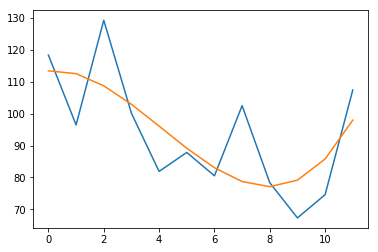

In [4]:
sample1 = Year2006.Phosphates
plot(sample1)
trendline1 = sample1 - Linearize(sample1)
plot(trendline1)

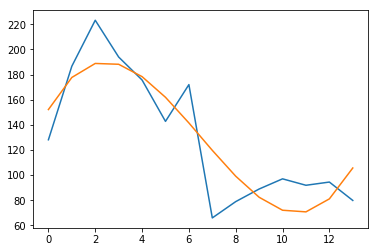

In [5]:
Year2007 = SurfaceVals[1]
sample2 = Year2007.Phosphates
plot(sample2)
trendline2 = sample2 - Linearize(sample2)
plot(trendline2)

#### Тесты Вилкоксона и Манна-Уитни

##### Для нестационарных рядов

In [6]:
print(stats.wilcoxon(sample1, sample2[:-2]))
print(stats.mannwhitneyu(sample1, sample2))

WilcoxonResult(statistic=9.0, pvalue=0.018602929901135743)
MannwhitneyuResult(statistic=54.0, pvalue=0.06459342558772746)


##### Для стационарных рядов

In [7]:
print(stats.wilcoxon(sample1 - trendline1, sample2[:-2] - trendline2[:-2]))
print(stats.mannwhitneyu(sample1 - trendline1, sample2 - trendline2))

WilcoxonResult(statistic=33.0, pvalue=0.6378701798979456)
MannwhitneyuResult(statistic=79.0, pvalue=0.40848066085769563)


#### Матрица корреляции на примере измерений за 2007 год

In [8]:
%%latex
$\tau{-критерий\ Кендала}$

<IPython.core.display.Latex object>

In [9]:
def LinearizeTable(table):
    result = pd.DataFrame(columns=header_names[2:])
    for i in header_names[2:]:
        result[i] = Linearize(table[i])
    return result

LinearizeTable(Year2007).corr(method='kendall')

,pH,Temp,Oxygen,BOD5,PO,Chlorides,Alkalinity,Ca,Mg,HardnessOfWater,Fe,Nitrites,Phosphates
pH,1.000000,0.274725,0.384615,0.450549,0.340659,0.384615,-0.296703,-0.186813,-0.120879,-0.186813,0.604396,-0.340659,0.186813
Temp,0.274725,1.000000,0.670330,0.164835,0.362637,0.670330,-0.010989,-0.252747,0.076923,0.054945,0.318681,-0.010989,0.604396
Oxygen,0.384615,0.670330,1.000000,0.318681,0.296703,0.516484,-0.032967,-0.054945,-0.120879,-0.142857,0.384615,-0.032967,0.670330
BOD5,0.450549,0.164835,0.318681,1.000000,0.098901,0.230769,-0.274725,-0.164835,-0.230769,-0.252747,0.274725,-0.318681,0.208791
PO,0.340659,0.362637,0.296703,0.098901,1.000000,0.560440,-0.208791,-0.406593,0.186813,0.120879,0.428571,-0.032967,0.142857
Chlorides,0.384615,0.670330,0.516484,0.230769,0.560440,1.000000,-0.032967,-0.318681,0.230769,0.208791,0.560440,0.010989,0.450549
Alkalinity,-0.296703,-0.010989,-0.032967,-0.274725,-0.208791,-0.032967,1.000000,0.318681,0.120879,0.230769,-0.208791,0.076923,0.208791
Ca,-0.186813,-0.252747,-0.054945,-0.164835,-0.406593,-0.318681,0.318681,1.000000,0.054945,0.164835,-0.142857,0.010989,0.010989
Mg,-0.120879,0.076923,-0.120879,-0.230769,0.186813,0.230769,0.120879,0.054945,1.000000,0.890110,0.054945,-0.142857,-0.098901
HardnessOfWater,-0.186813,0.054945,-0.142857,-0.252747,0.120879,0.208791,0.230769,0.164835,0.890110,1.000000,0.076923,-0.120879,-0.120879


#### Стаднартная ошибка и гистограмма коэффициентов корреляции между Жесткостью воды и содержанием кальция

0.08004901702463973


(array([0., 0., 1., 4., 1., 0.]),
 array([-1. , -0.6, -0.3,  0. ,  0.3,  0.6,  1. ]),
 <a list of 6 Patch objects>)

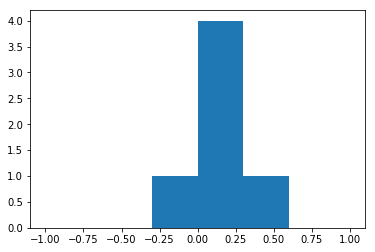

In [10]:
FilteredFrames = []
for i in SurfaceVals[:-2]:
    FilteredFrames.append(LinearizeTable(i))

CorrSample = []
for i in FilteredFrames[:-2]:
    CorrelationMatrix = i.corr()
    if 'Alkalinity' in CorrelationMatrix:
        CorrSample.append(i.corr().HardnessOfWater['Alkalinity'])
    else:
        continue

print(np.sqrt(np.var(CorrSample)/len(CorrSample)))
hist(CorrSample, bins=[-1, -0.6, -0.3, 0, 0.3, 0.6, 1])

#### Расчет 95%-го доверительного интервала при неизвестной функции распределения

In [11]:
%%latex
$$\bar{X} \pm \frac{U(p)sd}{\sqrt{n}}$$
$$U(p) = 1.96$$

<IPython.core.display.Latex object>

In [12]:
m = np.mean(CorrSample)
sd = np.sqrt(np.var(CorrSample))
n = len(CorrSample)
se = sd/np.sqrt(n)
print(r"(%f, %f)"%((m - 1.96*se), (m + 1.96*se)))

(0.039999, 0.353791)


In [13]:
FilteredFrames[7].fillna(0).corr()

,pH,Temp,Oxygen,BOD5,PO,Chlorides,Alkalinity,Ca,Mg,HardnessOfWater,Fe,Nitrites,Phosphates
pH,1.000000,-0.226268,0.400253,0.588971,0.384835,NaN,-0.016661,-0.192687,0.064897,-0.183196,NaN,-0.338614,0.485555
Temp,-0.226268,1.000000,-0.527544,0.353201,-0.573905,NaN,0.216540,0.299167,0.121335,0.012920,NaN,-0.381857,0.069854
Oxygen,0.400253,-0.527544,1.000000,0.002146,0.705988,NaN,-0.532073,-0.458136,-0.035784,-0.059230,NaN,0.038477,0.126020
BOD5,0.588971,0.353201,0.002146,1.000000,0.101137,NaN,0.337914,0.223210,-0.173504,-0.343705,NaN,-0.162301,0.397869
PO,0.384835,-0.573905,0.705988,0.101137,1.000000,NaN,-0.359375,-0.494977,-0.318479,-0.419711,NaN,0.342269,0.036573
Chlorides,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alkalinity,-0.016661,0.216540,-0.532073,0.337914,-0.359375,NaN,1.000000,0.308259,0.261205,0.168157,NaN,-0.228084,0.574454
Ca,-0.192687,0.299167,-0.458136,0.223210,-0.494977,NaN,0.308259,1.000000,-0.210555,0.277679,NaN,0.171089,-0.023152
Mg,0.064897,0.121335,-0.035784,-0.173504,-0.318479,NaN,0.261205,-0.210555,1.000000,0.787546,NaN,-0.596037,0.437894
HardnessOfWater,-0.183196,0.012920,-0.059230,-0.343705,-0.419711,NaN,0.168157,0.277679,0.787546,1.000000,NaN,-0.247507,0.203392


#### 95%-е доверительные интервалы коэффициентов корреляции для жесткости воды

In [14]:
def GetCorrelationList(list_of_frames, column):
    CorrSample = []
    for i in list_of_frames[:-2]:
        CorrelationMatrix = i.corr()
        if column in CorrelationMatrix:
            CorrSample.append(i.corr().HardnessOfWater[column])
        else:
            continue
    return CorrSample
    

def ConfidenceInterval(sample):
    m = np.mean(sample)
    sd = np.sqrt(np.var(sample))
    n = len(sample)
    se = sd/np.sqrt(n)
    return ((m - 1.96*se), (m + 1.96*se))


for i in header_names[2:]:
    print(r"%s: %s" % (i, ConfidenceInterval(GetCorrelationList(FilteredFrames[:-2], i))))

pH: (-0.26178796007221433, 0.06606011241526122)
Temp: (-0.1853394025177523, 0.1315956403533081)
Oxygen: (-0.544955647296553, -0.2631703890985251)
BOD5: (-0.2995854729972899, -0.034857647491626204)
PO: (-0.2675491166020205, 0.23029842276139784)
Chlorides: (-0.10414107772434322, 0.3555822481513891)
Alkalinity: (-0.015085395914387262, 0.44283583233835244)
Ca: (0.16706463312952885, 0.7991016249266247)
Mg: (0.2824924412230336, 0.8952955602477937)
HardnessOfWater: (1.0, 1.0)
Fe: (-0.503965120139674, 0.39588945256648433)
Nitrites: (0.104489138422526, 0.7453448667588369)
Phosphates: (-0.11309230480985465, -0.055193331866646)
